In [4]:
# imports

import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

import numpy as np
import gc

#import catboost ## thanks to yandex ! :) 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
# info about itertools.product: 
# https://pythonworld.ru/moduli/modul-itertools.html
# https://docs.python.org/2/library/itertools.html
from itertools import product

In [5]:
import tsfresh

# Работа с данными

Объеденим данные по месяцам:

In [6]:
eff_train = pd.read_csv('data/eff_train/eff_train1.csv', sep=';')
for x in range(2,11):
    eff_train_new = pd.read_csv('data/eff_train/eff_train{}.csv'.format(x), sep=';')
    eff_train = pd.concat([eff_train, eff_train_new])
eff_train = eff_train.rename(columns = {' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
eff_train.head(2)

,tag,timestamp,value,quality
0,Efficiency,01.10.2016 0:00,16137.70,Good
1,Efficiency,01.10.2016 0:00,16060.55,Good


In [7]:
eff_test1 = pd.read_csv('data/eff_test/eff_test1.csv', sep=';')
eff_test2 = pd.read_csv('data/eff_test/eff_test2.csv', sep=';')
eff_test = pd.concat([eff_test1, eff_test2])
eff_test = eff_test.rename(columns = {' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
eff_test.head(2)

,tag,timestamp,value,quality
0,Efficiency,01.08.2017 0:00,16836.91,Good
1,Efficiency,01.08.2017 0:00,17145.51,Good


In [8]:
energy_train = pd.read_csv('data/energy_cons_train/Energy_cons_train1.csv', sep=';')
for x in range(2,11):
    energy_train_new = pd.read_csv('data/energy_cons_train/Energy_cons_train{}.csv'.format(x), sep=';')
    energy_train = pd.concat([energy_train, energy_train_new])
energy_train = energy_train.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
energy_train.head(2)

,tag,timestamp,value,quality
0,Energy_cons,01.10.2016 0:01,20.347508,Good
1,Energy_cons,01.10.2016 0:02,20.24238,Good


In [9]:
energy_test = pd.read_csv('data/energy_cons_test/Energy_cons_test1.csv', sep=';')
x=2
energy_test_new = pd.read_csv('data/energy_cons_test/Energy_cons_test{}.csv'.format(x), sep=';')
energy_test = pd.concat([energy_test, energy_test_new])
energy_test = energy_test.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
energy_test.head(2)

,tag,timestamp,value,quality
0,Energy_cons,01.08.2017 0:01,17.324733,Good
1,Energy_cons,01.08.2017 0:02,17.46305,Good


In [10]:
qual_train = pd.read_csv('data/qual_train/qual_train1.csv', sep=';') 
for x in range(2,11): 
    qual_train_new = pd.read_csv('data/qual_train/qual_train{}.csv'.format(x), sep=';') 
    qual_train = pd.concat([qual_train, qual_train_new], ignore_index = True) 
qual_train = qual_train.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'}) 
qual_train.head(2)

,tag,timestamp,value,quality
0,Quality,01.10.2016 0:38,2.2,Good
1,Quality,01.10.2016 1:02,2.2,Good


In [11]:
qual_test = pd.read_csv('data/qual_test/qual_test1.csv', sep=';') 
x=2 
qual_test_new = pd.read_csv('data/qual_test/qual_test{}.csv'.format(x), sep=';') 
qual_test = pd.concat([qual_test, qual_test_new]) 
qual_test = qual_test.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'}) 
qual_test.head(2)

,tag,timestamp,value,quality
0,Quality,01.08.2017 0:14,2.2,Good
1,Quality,01.08.2017 0:38,2.2,Good


Объеденим трэйн и тест:

In [12]:
eff_all = pd.concat([eff_train, eff_test])
qual_all = pd.concat([qual_train, qual_test])
energy_all = pd.concat([energy_train, energy_test])

преобразуем колонку timestamp в тип datetime:

In [13]:
eff_all["timestamp"] = pd.to_datetime(eff_all["timestamp"], format = '%d.%m.%Y %H:%M')
qual_all["timestamp"] = pd.to_datetime(qual_all["timestamp"], format = '%d.%m.%Y %H:%M')
energy_all["timestamp"] = pd.to_datetime(energy_all["timestamp"], format = '%d.%m.%Y %H:%M')

In [14]:
eff_all.head(2)

,tag,timestamp,value,quality
0,Efficiency,2016-10-01,16137.70,Good
1,Efficiency,2016-10-01,16060.55,Good


In [15]:
qual_all.head(2)

,tag,timestamp,value,quality
0,Quality,2016-10-01 00:38:00,2.2,Good
1,Quality,2016-10-01 01:02:00,2.2,Good


In [16]:
energy_all.head()

,tag,timestamp,value,quality
0,Energy_cons,2016-10-01 00:01:00,20.347508,Good
1,Energy_cons,2016-10-01 00:02:00,20.24238,Good
2,Energy_cons,2016-10-01 00:03:00,20.208391,Good
3,Energy_cons,2016-10-01 00:04:00,20.239189,Good
4,Energy_cons,2016-10-01 00:05:00,20.262808,Good


Уберем мусор в данных:

In [17]:
energy_all["value"] = pd.to_numeric(energy_all["value"], downcast = 'float', errors='coerse')
energy_all = energy_all[energy_all["value"].notnull()]

In [18]:
energy_all = energy_all[energy_all["quality"] == "Good"]
qual_all = qual_all[qual_all["quality"] == "Good"]
eff_all = eff_all[eff_all["quality"] == "Good"]
eff_all = eff_all[eff_all["value"] > 0.0]
#qual_all = qual_all[qual_all["value"] > 0.0]
#energy_all = energy_all[energy_all["value"] > 0.0]

# Визуализируем данные

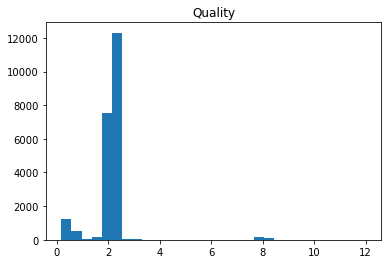

In [19]:
plt.hist(qual_all["value"], 30)
plt.title("Quality")
plt.show()

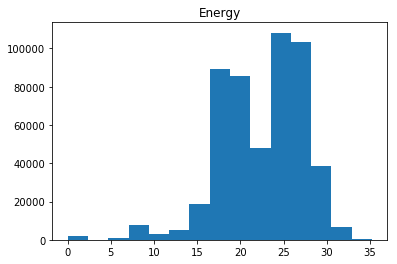

In [20]:
plt.hist(energy_all["value"], 15)
plt.title("Energy")
plt.show()

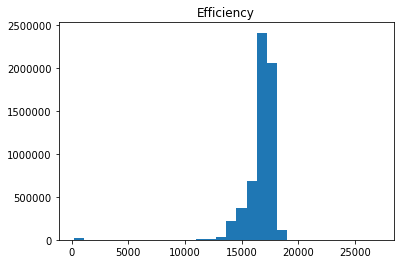

In [21]:
plt.hist(eff_all["value"], 30)
plt.title("Efficiency")
plt.show()

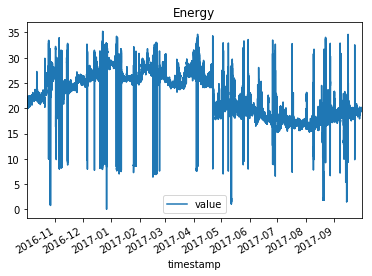

In [22]:
energy_all.plot(x = 'timestamp', y = 'value')
plt.title("Energy")

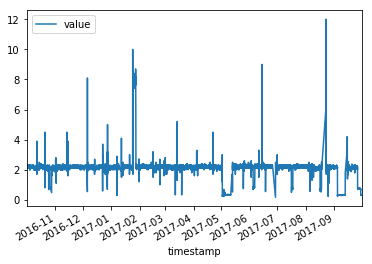

In [23]:
qual_all.plot(x = 'timestamp', y = 'value')

In [24]:
eff_all.shape

(5920437, 4)

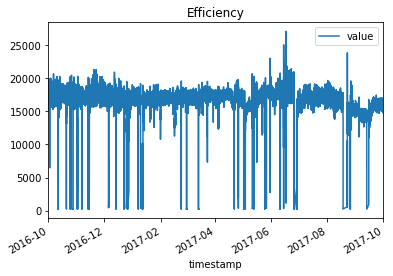

In [25]:
eff_all.plot(x = 'timestamp', y = 'value')
plt.title("Efficiency")

In [26]:
gb = eff_all.groupby("timestamp").value.mean()
gb.head()

timestamp
2016-10-01 00:00:00    16751.067273
2016-10-01 00:01:00    16669.921667
2016-10-01 00:02:00    16979.655833
2016-10-01 00:03:00    16527.832500
2016-10-01 00:04:00    16829.427500
Name: value, dtype: float64

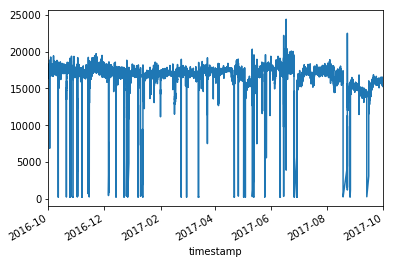

In [27]:
gb.plot()

In [28]:
eff_new = pd.DataFrame()
eff_new['timestamp'] = eff_all.groupby("timestamp").value.mean().index
eff_new['value'] = eff_all.groupby("timestamp").value.mean().values
eff_new.head()

,timestamp,value
0,2016-10-01 00:00:00,16751.067273
1,2016-10-01 00:01:00,16669.921667
2,2016-10-01 00:02:00,16979.655833
3,2016-10-01 00:03:00,16527.832500
4,2016-10-01 00:04:00,16829.427500


In [29]:
eff_new['day'] = (eff_new['timestamp'].values).astype('datetime64[D]').astype(int)-np.datetime64('2016-10-01').astype('datetime64[D]').astype(int)

In [30]:
mean = eff_new.groupby("day").value.mean() 
df = pd.DataFrame({'mean_value': mean, 'day': eff_new['day'].unique()}) 
eff_new = pd.merge(eff_new, df, how = 'left', on = 'day') 
eff_new

,timestamp,value,day,mean_value
0,2016-10-01 00:00:00,16751.067273,0,17138.604496
1,2016-10-01 00:01:00,16669.921667,0,17138.604496
2,2016-10-01 00:02:00,16979.655833,0,17138.604496
3,2016-10-01 00:03:00,16527.832500,0,17138.604496
4,2016-10-01 00:04:00,16829.427500,0,17138.604496
5,2016-10-01 00:05:00,16781.086667,0,17138.604496
6,2016-10-01 00:06:00,16684.245000,0,17138.604496
7,2016-10-01 00:07:00,16748.291667,0,17138.604496
8,2016-10-01 00:08:00,16735.678333,0,17138.604496
9,2016-10-01 00:09:00,16825.033333,0,17138.604496


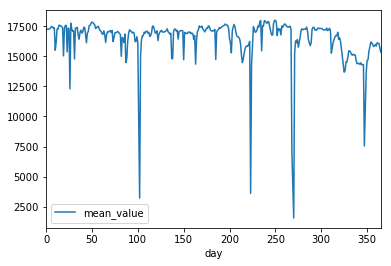

In [31]:
eff_new.plot(x = 'day', y = 'mean_value')

In [32]:
eff_new.head()

,timestamp,value,day,mean_value
0,2016-10-01 00:00:00,16751.067273,0,17138.604496
1,2016-10-01 00:01:00,16669.921667,0,17138.604496
2,2016-10-01 00:02:00,16979.655833,0,17138.604496
3,2016-10-01 00:03:00,16527.832500,0,17138.604496
4,2016-10-01 00:04:00,16829.427500,0,17138.604496


In [33]:
eff_lag_1 = df[['day', 'mean_value']].copy()
eff_lag_1['day'] = df['day']  + 1
eff_lag_1.head()

,day,mean_value
day,,
0,1,17138.604496
1,2,17260.405627
2,3,17266.331459
3,4,17257.291270
4,5,17297.343270


In [34]:
# !! Don't use old data !! 
df_new = df[df['day'] >= 1] 


df_super_new = pd.merge(df_new, eff_lag_1, how='left', on='day')

df_super_new.head()

,day,mean_value_x,mean_value_y
0,1,17260.405627,17138.604496
1,2,17266.331459,17260.405627
2,3,17257.291270,17266.331459
3,4,17297.343270,17257.291270
4,5,17373.285393,17297.343270


In [35]:
# !! Don't use old data !! 
df_new = df[df['day'] >= 1] 

df_super_new = pd.merge(df_new, eff_lag_1, how='left', on='day')

df_diff = df_super_new['mean_value_y'].values - df_super_new['mean_value_x'].values
df_diff = pd.DataFrame({'day': df_super_new['day'].values, 'diff_value': df_diff})
df_diff.head()

df_super_new = pd.merge(df_super_new, df_diff, how = 'left', on='day')
df_super_new.head()

,day,mean_value_x,mean_value_y,diff_value
0,1,17260.405627,17138.604496,-121.801131
1,2,17266.331459,17260.405627,-5.925832
2,3,17257.291270,17266.331459,9.040189
3,4,17297.343270,17257.291270,-40.052000
4,5,17373.285393,17297.343270,-75.942123


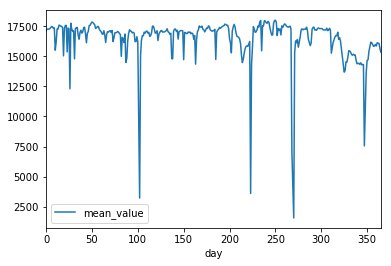

In [36]:
df.plot(x = 'day', y = 'mean_value')

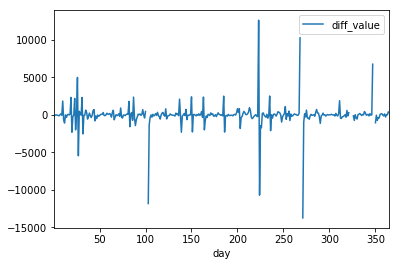

In [37]:
df_super_new.plot(x = 'day', y = 'diff_value')

In [38]:
from statsmodels.tsa.arima_model import ARIMA

# Разметрка аномалий

In [39]:
eff_new['probability'] = 0
eff_new.loc[eff_new.mean_value <15000., 'probability'] = 1

# Разбиваем данные на train test

In [40]:
eff_train = eff_new[eff_new['day'] < 300]
eff_test = eff_new[eff_new['day'] >= 300]

In [41]:
X_train_eff = eff_train.drop(['day', 'value', 'probability'], axis = 1)
X_test_eff = eff_test.drop(['day', 'value', 'probability'], axis = 1)
y_train_eff = eff_train['probability'].values.astype(int)
y_test_eff = eff_test['probability'].values.astype(int)

In [42]:
X_train_eff.head()

,timestamp,mean_value
0,2016-10-01 00:00:00,17138.604496
1,2016-10-01 00:01:00,17138.604496
2,2016-10-01 00:02:00,17138.604496
3,2016-10-01 00:03:00,17138.604496
4,2016-10-01 00:04:00,17138.604496


In [43]:
X_test_eff.head()

,timestamp,mean_value
410159,2017-07-28 00:00:00,17311.449795
410160,2017-07-28 00:01:00,17311.449795
410161,2017-07-28 00:02:00,17311.449795
410162,2017-07-28 00:03:00,17311.449795
410163,2017-07-28 00:04:00,17311.449795


In [44]:
y_test_eff.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
from matplotlib.ticker import MultipleLocator
from matplotlib import dates

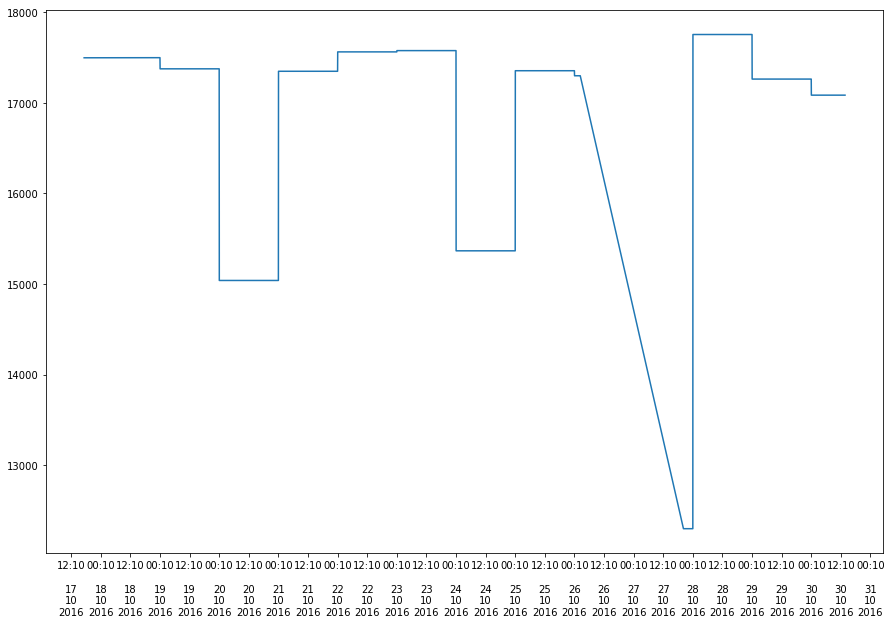

In [145]:
X = X_train_eff[24000:40000]['timestamp']
Y = X_train_eff[24000:40000]['mean_value']

fig, ax = plt.subplots(1, figsize=(15, 10))
ax.plot(X, Y)

majorLocator = MultipleLocator(0.5)
ax.xaxis.set_major_locator(majorLocator)

ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%m'))
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%m\n\n%d\n%m\n%Y'))


In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

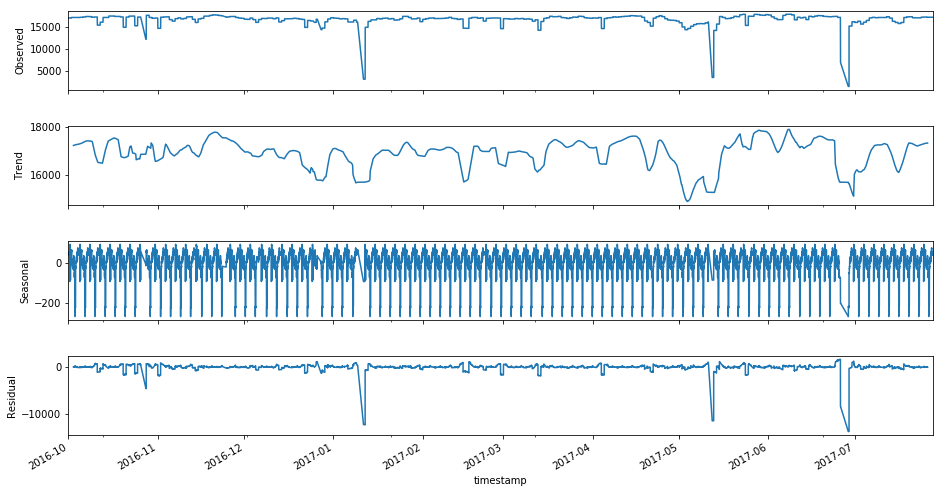

In [56]:
decomposition = seasonal_decompose(pd.Series(data = X_train_eff['mean_value'].values.tolist(), index = X_train_eff['timestamp']), freq=5000)  
fig = plt.figure()  
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [57]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

In [83]:
df = eff_new.drop(['day', 'value', 'probability'], axis = 1)
time = pd.to_datetime(df['timestamp'])
ser = pd.Series(data=df['mean_value'].values.tolist(), index=time)

/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


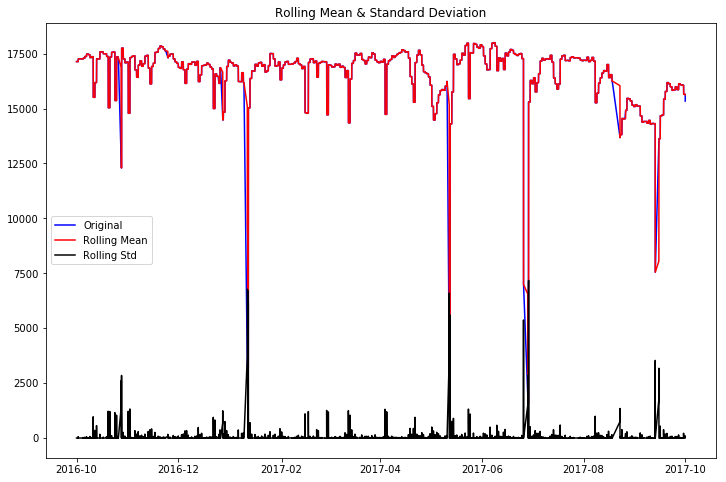

In [66]:


test_stationarity(pd.Series(data = df['mean_value'].values.tolist(), index=df['timestamp']))

In [84]:
ser.head()

timestamp
2016-10-01 00:00:00    17138.604496
2016-10-01 00:01:00    17138.604496
2016-10-01 00:02:00    17138.604496
2016-10-01 00:03:00    17138.604496
2016-10-01 00:04:00    17138.604496
dtype: float64

In [80]:
def ses_decomp(timeseries):
    decomposition = seasonal_decompose(timeseries, freq=5000)  
    fig = plt.figure()  
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)

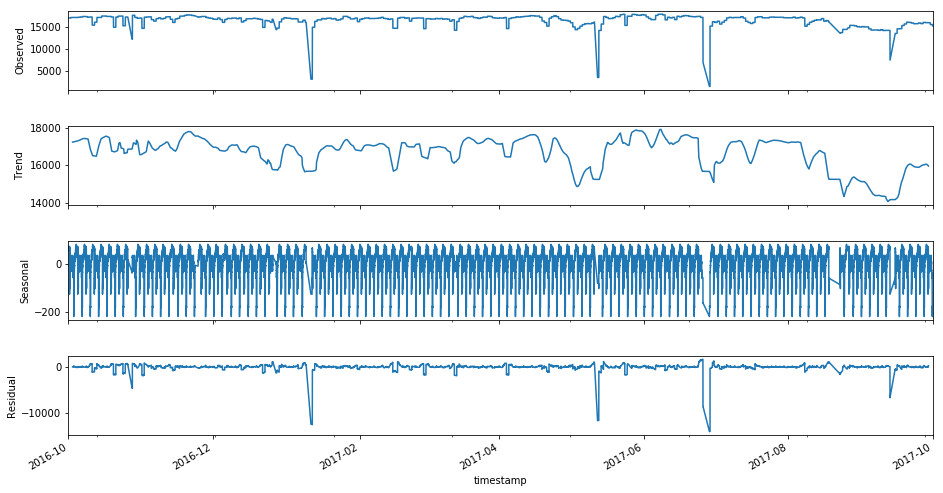

In [81]:
decomposition = seasonal_decompose(ser, freq=5000)  
fig = plt.figure()  
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [93]:
data = (df['mean_value'] - df['mean_value'].shift(1)).fillna(17000.)

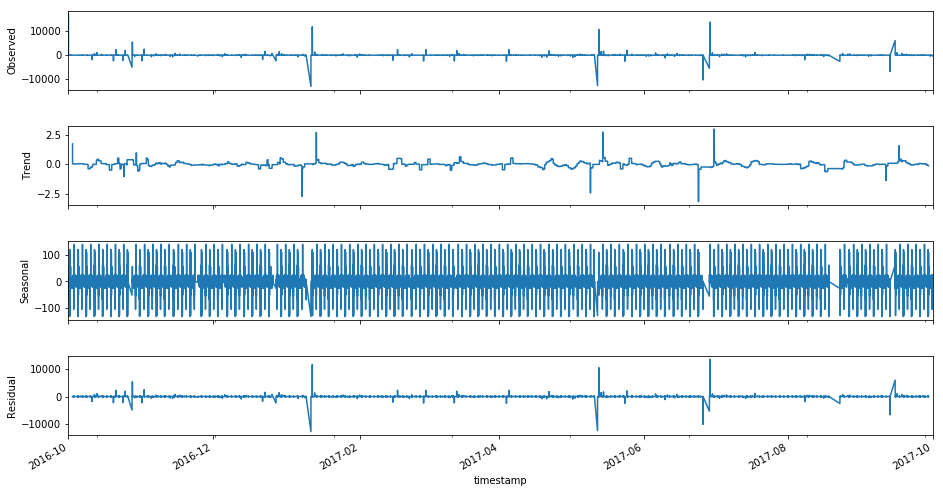

In [94]:
ses_decomp(pd.Series(data = data.values.tolist(), index=time))

# Тренируем ARIMA

In [95]:
ser_train = pd.Series(data = X_train_eff['mean_value'].values.tolist(), index = X_train_eff['timestamp'])
model = ARIMA(ser_train, order = (5, 0, 1))
model_fit = model.fit(disp = 0)

/usr/local/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [96]:
pred = model_fit.forecast(steps=len(X_test_eff))

ser_test = pd.Series(data = X_test_eff['mean_value'].values.tolist(), index = X_test_eff['timestamp'])
ser_pred = pd.Series(data = pred[0], index = X_test_eff['timestamp'])


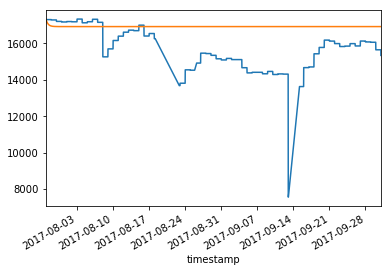

In [97]:
ser_test.plot()
ser_pred.plot()